In [4]:
import os
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from env.EV_Sce_Env import EV_Sce_Env
import math
import seaborn as sns
import numpy as np

env = EV_Sce_Env('SY_2', seed=0)

In [5]:
#哈佛大学Data Science课程CS109推荐的matplotlib 默认设置
#可以方便的设置一次，保证整体风格一致
from matplotlib import rcParams
# #图片大小
# rcParams['figure.figsize'] = (10, 6)
# #图片精度
# rcParams['figure.dpi'] = 150
# #线宽
# rcParams['lines.linewidth'] = 2
#是否显示网格
rcParams['axes.grid'] = True
#axes 填充颜色为浅灰
rcParams['axes.facecolor'] = '#eeeeee'
# #字体大小为14
# rcParams['font.size'] = 14
#边框为无色
rcParams['patch.edgecolor'] = 'none'

In [6]:
T1 = 'T1'
env_name = 'SY_4'
mathlod = ['GA', 'OR', 'OC', 'NGH', 'GH']
sce = ['SY_2', 'SY_3', 'SY_4']
dir = {}
for i in mathlod:
    dir[i] = 'output/{}_{}_{}'.format(env_name, T1, i)

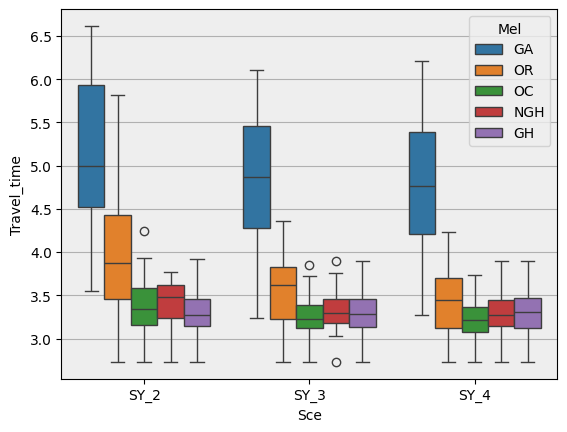

In [7]:
travel_time = pd.DataFrame(columns=['EV', 'Mel', 'Sce', 'Reward', 'Travel_time'])
j = 0
for s in sce:
    for m in mathlod:
        df_evg = pd.read_csv('output/{}_{}_{}/EV_g.csv'.format(s, T1, m))
        for i in range(df_evg.shape[0]):
            travel_time.loc[j] = [
                df_evg.iloc[i]['EV'], 
                m, 
                s,
                df_evg.iloc[i]['Reward'],
                df_evg.iloc[i]['Total']
            ]
            j += 1
# ax = sns.boxplot(y="Reward", x="Sce", hue='Mel', data=travel_time)
ax = sns.boxplot(y="Travel_time", x="Sce", hue='Mel', data=travel_time)
plt.savefig('Travel_time.png', dpi=300, bbox_inches='tight')

In [8]:
s = "SY_4"
for m in mathlod:
    print(m, 'avg', travel_time.query('Mel=="{}" & Sce=="{}"'.format(m, s))['Travel_time'].mean())
    print(m, 'std', travel_time.query('Mel=="{}" & Sce=="{}"'.format(m, s))['Travel_time'].std())

GA avg 4.821319444444445
GA std 0.7845526405699947
OR avg 3.4232916666666666
OR std 0.3544701429679898
OC avg 3.232291666666667
OC std 0.24795153937097605
NGH avg 3.297041666666666
NGH std 0.2727423952235861
GH avg 3.3019999999999996
GH std 0.2501425455684184


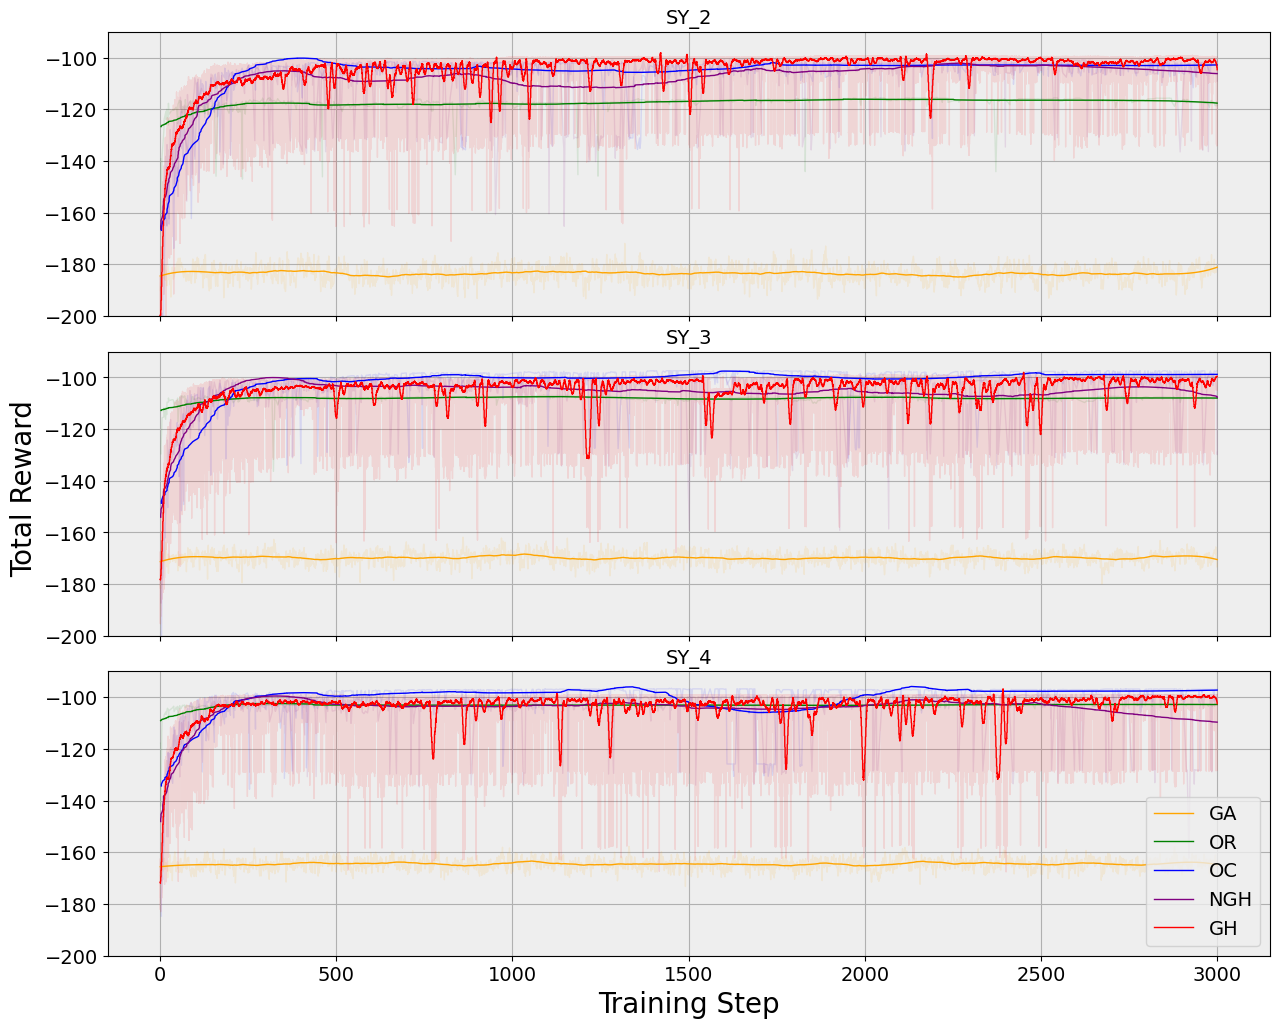

In [9]:
s = 'SY_4'
m_c = {
    'GA': 'orange',
    'OC': 'blue',
    'OR': 'green',
    'NGH': 'purple',
    'GH': 'red'
}

fig, axs = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(15, 12))
for i, s in enumerate(sce):
    ax = axs[i]
    df_dic = {}
    for m in mathlod:
        for f in os.listdir('reward'):
            if m in f.split('_') and s in f:
                df = pd.read_csv('reward/' + f)
                df_dic[m] = df
                
    for m in mathlod:
        df = df_dic[m]
        ax.plot(df['Step'], df['Value'], c=m_c[m], linewidth=1, alpha=0.1)
    for m in mathlod:
        df = df_dic[m]
        smooth = scipy.signal.savgol_filter(df['Value'], 301, 3)
        ax.plot(df['Step'], smooth, c=m_c[m], linewidth=1, label=m)
    ax.set_ylim([-200, -90])
    ax.set_title(s, fontsize=14)
    if i == 2:
        ax.legend(loc='lower right', fontsize=14)
        ax.set_xlabel('Training Step', fontsize=20)
    ax.tick_params(
            axis='y',
            labelsize=14,
        )
    ax.tick_params(
            axis='x',
            labelsize=14,
        )

fig.text(0.06, 0.5, 'Total Reward', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(
        left=None, 
        bottom=None, 
        right=None, 
        top=None, 
        hspace=0.125
    ) # 间距
plt.savefig('Total_reward.png', dpi=300, bbox_inches='tight')
plt.show()

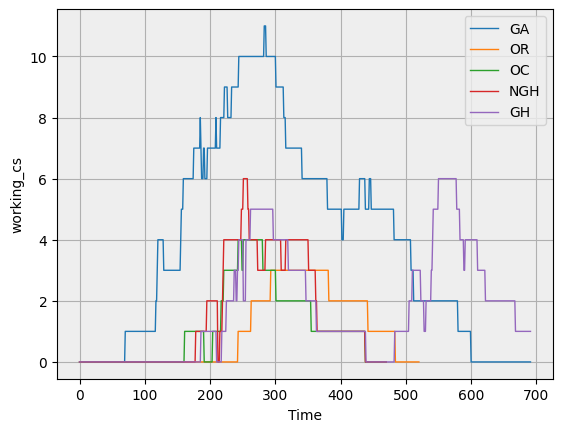

In [10]:
working_cs = pd.DataFrame(columns=mathlod)
for m in mathlod:
    df_cs = pd.read_csv('output/{}_{}_{}/CS.csv'.format(env_name, T1, m))

    columns = []
    for i in range(1, env.num_cs-1):
        columns.append('CS{}_charging_num'.format(i))

    df_cs['working_cs'] = (df_cs[columns]>0).sum(axis=1)
    # working_cs['Time'] = df_cs['time']
    working_cs[m] = df_cs['working_cs']

plt.plot(
    working_cs, label=working_cs.columns,
    linewidth=1
    )
plt.xlabel('Time')
plt.ylabel('working_cs')
plt.legend()

In [11]:
for s in sce:
    for m in mathlod:
        df_evg = pd.read_csv('output/{}_{}_{}/CS.csv'.format(s, T1, m))
        print(s, m, df_evg.shape[0])

SY_2 GA 760
SY_2 OR 677
SY_2 OC 522
SY_2 NGH 471
SY_2 GH 490
SY_3 GA 682
SY_3 OR 533
SY_3 OC 483
SY_3 NGH 463
SY_3 GH 471
SY_4 GA 692
SY_4 OR 521
SY_4 OC 471
SY_4 NGH 471
SY_4 GH 760


In [12]:
route_con = {}
route_list = {}
for i in range(env.agent_num):
    ev_id = i
    df_r = pd.read_csv('output/SY_2_T1_GH/EV/EV{}_route.csv'.format(ev_id))
    route = list(df_r['edge'])
    r = route[0]
    for j in range(1, len(route)):
        next_p = route[j].split('-')[-1]
        r += "-"+next_p
    if r not in route_con.keys():
        route_con[r] = 1
        route_list[r] = [ev_id]
    else:
        route_con[r] += 1
        route_list[r].append(ev_id)
GH_route = route_con

route_con = {}
route_list = {}
for i in range(env.agent_num):
    ev_id = i
    df_r = pd.read_csv('output/SY_2_T1_NGH/EV/EV{}_route.csv'.format(ev_id))
    route = list(df_r['edge'])
    r = route[0]
    for j in range(1, len(route)):
        next_p = route[j].split('-')[-1]
        r += "-"+next_p
    if r not in route_con.keys():
        route_con[r] = 1
        route_list[r] = [ev_id]
    else:
        route_con[r] += 1
        route_list[r].append(ev_id)
NGH_route = route_con

In [13]:
route_set = list(set(list(GH_route.keys()) + list(NGH_route.keys())))
df_route = pd.DataFrame(columns=['Route', 'Mel', 'Con'])
i = 0
for j, r in enumerate(route_set):
    df_route.loc[i, 'Route'] = 'Route_' + str(j+1)
    df_route.loc[i, 'Mel'] = 'GH'
    df_route.loc[i, 'Con'] = GH_route[r] if r in GH_route.keys() else 0
    i += 1
    df_route.loc[i, 'Route'] = 'Route_' + str(j+1)
    df_route.loc[i, 'Mel'] = 'NGH'
    df_route.loc[i, 'Con'] = NGH_route[r] if r in NGH_route.keys() else 0
    i += 1

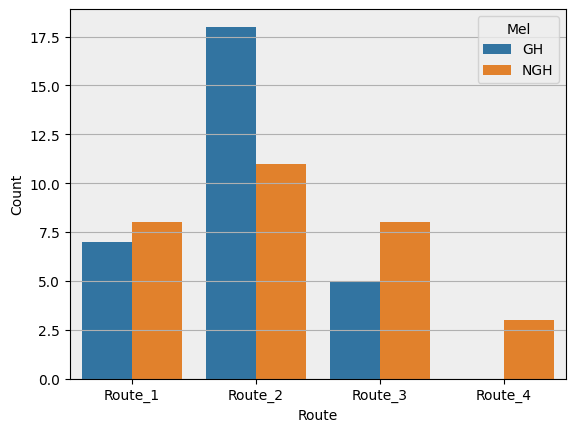

In [14]:
ax = sns.barplot(y="Con", x='Route', hue='Mel', data=df_route, errorbar=('ci', 0))
# ax.set_ylim(0, 1)
ax.set_ylabel('Count')
plt.savefig('Routes.png', dpi=300)
plt.show()

In [15]:
route_set

['0-10-11-12-7-8-9-19',
 '0-10-11-14-15-16-19',
 '0-10-11-12-7-4-19',
 '0-5-6-7-8-9-19']

In [16]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("WR", ["#eeeeee", "red"])
rcParams['axes.grid'] = False

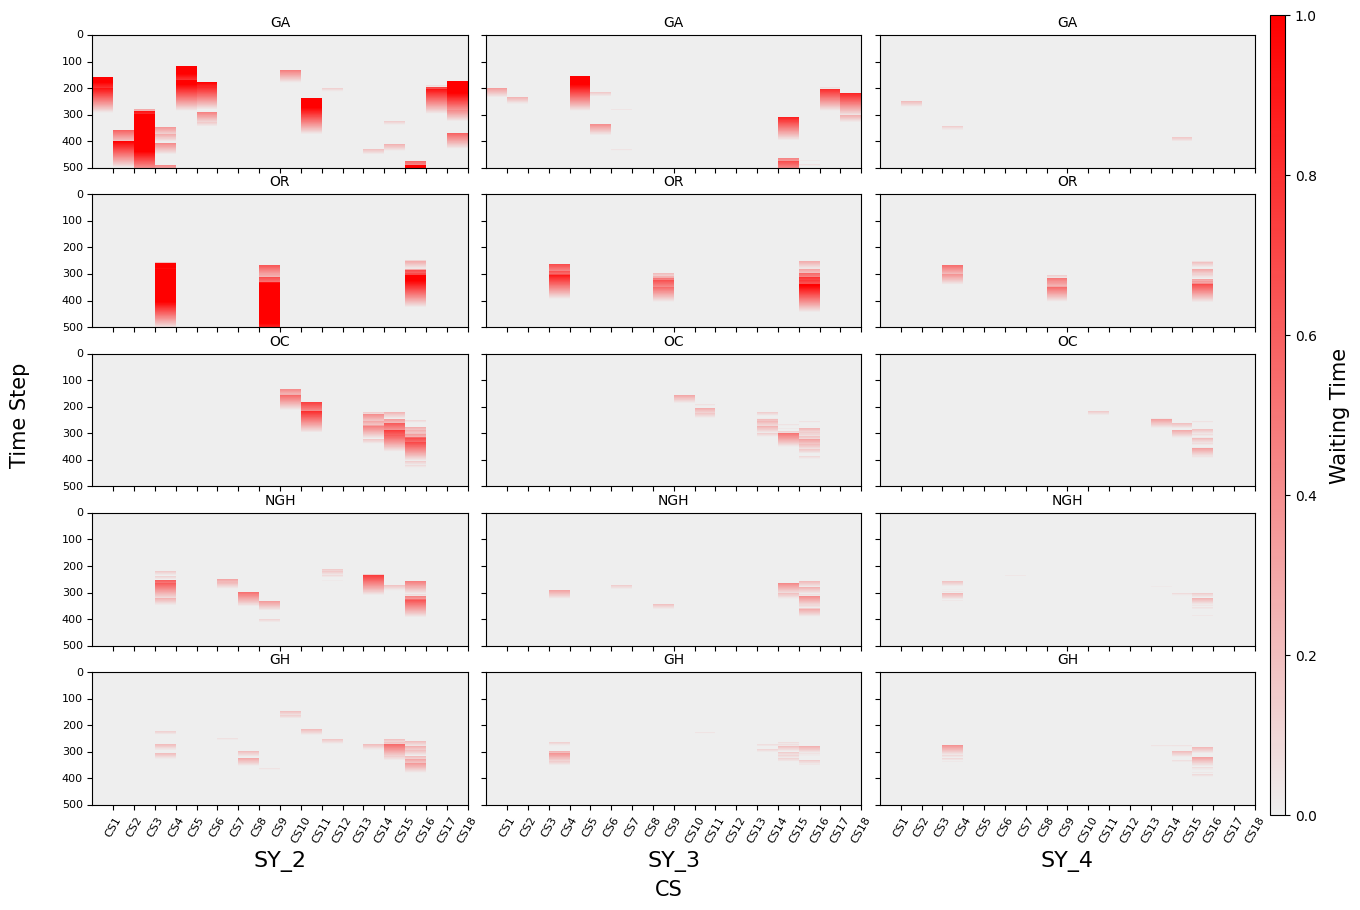

In [17]:
fig, axs = plt.subplots(5, 3, figsize=(15, 10), sharex='col', sharey='row')

for j, s in enumerate(sce):
    for i, m in enumerate(mathlod):
        df_cs = pd.read_csv('output/{}_{}_{}/CS.csv'.format(s, T1, m))
        ax = axs[i][j]
        waiting_time = np.array(df_cs[['CS{}_waiting_time'.format(id) for id in range(1, env.num_cs-1)]])
        zero_m = np.zeros_like(waiting_time)
        waiting_time = np.concatenate((waiting_time, zero_m), axis=0)[:500]
        sns.heatmap(
                waiting_time, 
                ax=ax, cmap=cmap, vmin=0, vmax=1,
                cbar=False
            )
        ax.set_title(m, fontsize=10)
        if i == 4:
            ax.set_xlabel(s, fontsize=16)
        ax.set_xticks(range(1, env.num_cs-1))
        ax.set_xticklabels(['CS{}'.format(id) for id in range(1, env.num_cs-1)])
        ax.set_yticks(range(0, 501, 100))
        ax.set_yticklabels(range(0, 501, 100), rotation=0)
        ax.spines['left'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.tick_params(
                axis='y',
                labelsize=8,
                rotation=0
            )
        ax.tick_params(
                axis='x',
                labelsize=8,
                rotation=60
            )
fig.text(0.07, 0.5, 'Time Step', va='center', rotation='vertical', fontsize=15)
fig.text(0.5, 0.025, 'CS', va='center', fontsize=15)
fig.text(0.95, 0.5, 'Waiting Time', va='center', rotation='vertical', fontsize=15)
cb_ax = fig.add_axes([0.91, 0.1, 0.01, 0.8])  # type: ignore # 位置参数需要根据情况调整
cb = fig.colorbar(ax.collections[0], cax=cb_ax)
cb.ax.tick_params(labelsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.2)
plt.savefig('hotmap.png', dpi=300, bbox_inches='tight')
plt.show()